In [1]:
from collections import Counter
from pprint import pprint
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import linalg as LA

from sklearn.manifold import TSNE

In [2]:
FILE_NAME = '64_relu_30_5_adjacentTF_1e-4'
DATA_DIR = Path("../../data/")

we first explore the original graph (before embedding)

In [3]:
data_processor = Preprocess()
df = data_processor.raw2train(DATA_DIR)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
8752
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [4]:
emb_df = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)
tf_emb_df = emb_df[emb_df['type'] != 0]
emb_df = emb_df.drop(['type'], axis='columns')



In [5]:
# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=80, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
# edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

Running KNN...
KNN completed!
Creating edgelist...


source   target  distance
0  MCHR1   BDKRB1  0.048990
1  MCHR1   CARD16  0.060307
2  MCHR1   CYP7B1  0.063394
3  MCHR1  CCDC74B  0.063494
4  MCHR1    MGST2  0.065220

In [6]:
# G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target']], 'source', 'target', create_using=nx.Graph)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 1117177
Average degree: 120.3012


In [7]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G, resolution=2.5, random_state=0)
max(set(partition.values()))

6

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [8]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({6: 69})
Cluster of GM:  Counter({6: 69})
Cluster of normal gene:  Counter({0: 6367, 1: 4912, 2: 3249, 4: 2006, 5: 1410, 3: 487, 6: 4})


In the embedding space, we want to calculate the distance between each cluster and the TF cluster. To save computational power, the distance is calculate as the distance between the middle points of respective clusters

In [9]:

mean_clusters = emb_df.groupby('class').mean()
tf_mean = tf_emb_df.drop('type', axis=1).mean(axis=0).to_numpy()

def get_dist(x):
    return LA.norm(x.to_numpy() - tf_mean)
mean_clusters['distance_to_tf'] = mean_clusters.apply(get_dist, axis=1)
mean_clusters[['distance_to_tf']].sort_values('distance_to_tf')

distance_to_tf
class                
6            0.019414
1            0.888397
2            1.015872
3            1.053579
0            1.063739
5            1.072337
4            1.082261

In [10]:

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters.drop('distance_to_tf', axis=1))

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed

Running TSNE...
Mapping names to classes...


0          1  type
MCHR1   30.463913 -26.405504     0
PSMD9  -14.072628 -38.986301     0
CRIP1  -49.249290  33.980366     0
GIMAP4 -59.508717 -12.049829     0
GATM    72.720993  15.512796     0
...           ...        ...   ...
2      -41.283943  32.197926    10
3       13.428054 -66.605499    10
4       65.126389  15.647252    10
5        6.520201  55.501476    10
6      -76.456085  -8.700488    10

[18580 rows x 3 columns]

In [11]:
mean_clusters = emb_df.groupby('class').mean()
tf_mean = tf_emb_df.drop('type', axis=1).mean(axis=0).to_numpy()

def get_dist(x):
    return LA.norm(x.to_numpy() - tf_mean)
mean_clusters['distance_to_tf'] = mean_clusters.apply(get_dist, axis=1)
mean_clusters[['distance_to_tf']].sort_values('distance_to_tf')

distance_to_tf
class                
6            0.019414
1            0.888397
2            1.015872
3            1.053579
0            1.063739
5            1.072337
4            1.082261

In [12]:

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters.drop('distance_to_tf', axis=1))

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed

Running TSNE...
Mapping names to classes...


0          1  type
MCHR1   30.463913 -26.405504     0
PSMD9  -14.072628 -38.986301     0
CRIP1  -49.249290  33.980366     0
GIMAP4 -59.508717 -12.049829     0
GATM    72.720993  15.512796     0
...           ...        ...   ...
2      -41.283943  32.197926    10
3       13.428054 -66.605499    10
4       65.126389  15.647252    10
5        6.520201  55.501476    10
6      -76.456085  -8.700488    10

[18580 rows x 3 columns]

In [13]:
Path(f"./result/{FILE_NAME}").mkdir(parents=True, exist_ok=True)

We could also color the graph by the class of each node

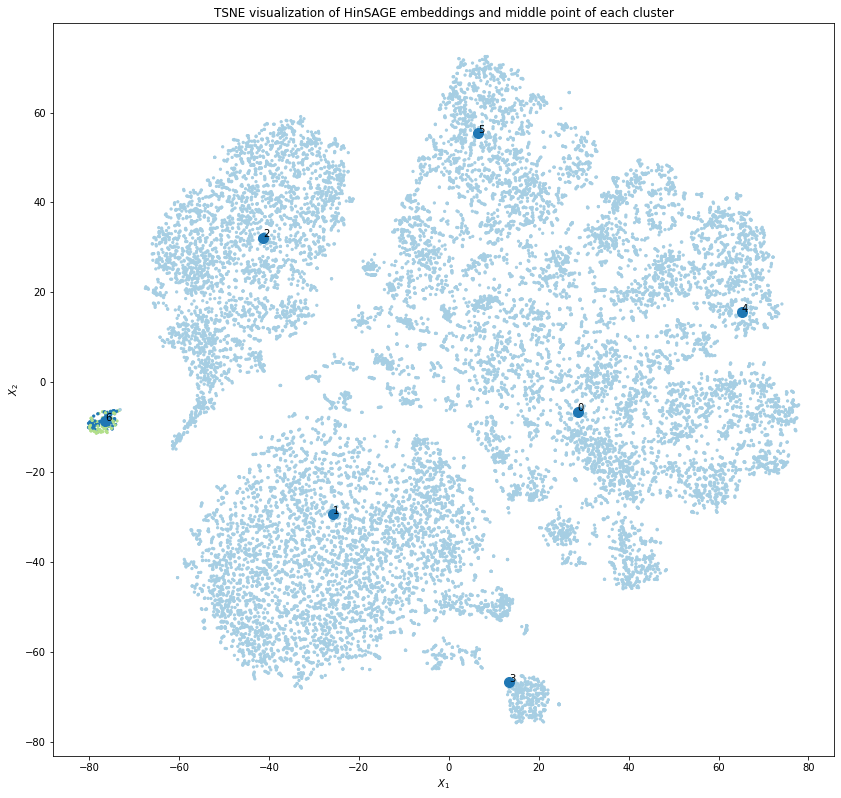

In [14]:
g, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    # alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)

# Annotate ID of each cluster
n_clusters = max(set(partition.values())) + 1
for i in range(n_clusters):
    ax.annotate(str(i), (emb_transformed[emb_transformed['type'] == 10].loc[i][0]+.05, emb_transformed[emb_transformed['type'] == 10].loc[i][1]+.05))
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings and middle point of each cluster")

# plt.savefig(f'./result/{FILE_NAME}/cluster.png', dpi=150)
plt.show()


In [15]:
_idx = list(emb_df.columns)[:-1]

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(emb_df[_idx]), index=emb_df.index)
emb_transformed['class'] = emb_df['class']


Running TSNE...


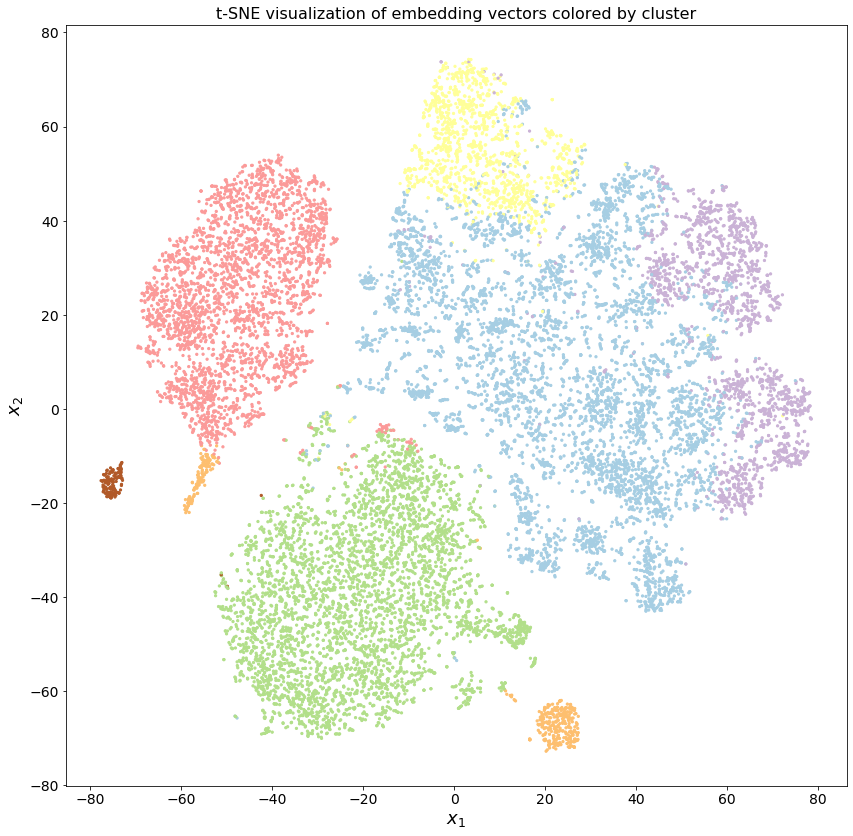

In [16]:


fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["class"],
    cmap="Paired",
    # alpha=.7,
    s=5,
)

ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title(f"t-SNE visualization of embedding vectors colored by cluster", fontsize=16)

# plt.savefig(f'./result/{FILE_NAME}/individual_cluster.svg', dpi=150)
plt.show()

We could calculate the distance between clusters, the distance is defined as how many hops are needed from one node to another

In [17]:
gms = list(gm_cluster_df.index)
ks = list(k_cluster_df.index)
genes = list(gene_cluster_df.index)

print(len(genes))
cluster_df

18435


class  is_tf
MCHR1         0      0
PSMD9         1      0
CRIP1         2      0
GIMAP4        3      0
GATM          4      0
...         ...    ...
ERCC5         1      0
MARVELD1      5      0
YTHDC2        2      0
SRC           1      0
C1GALT1       0      0

[18573 rows x 2 columns]

In [18]:
shortest_paths = {}
tfs = gms + ks

shortest_paths_df = pd.DataFrame(index=genes, columns=tfs, dtype=np.int16)

for tf in tfs:
    shortest_paths[tf] = nx.shortest_path_length(G_original, source=tf)

In [19]:
shortest_paths_df = pd.DataFrame(shortest_paths)
shortest_paths_df = shortest_paths_df[~shortest_paths_df.index.isin(tfs)]
shortest_paths_df.sort_index(inplace=True)

shortest_paths_cluster = cluster_df[cluster_df.index.isin(shortest_paths_df.index)].sort_index()
# shortest_paths_cluster
shortest_paths_df['cluster'] = shortest_paths_cluster['class']

# Mode
# cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').agg(lambda x:x.value_counts().index[0]).to_frame().sort_values([0])

# Mean
cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').mean().to_frame().sort_values([0])

# cluster_rank.to_csv(f'./result/{FILE_NAME}/cluster_rank.csv', index=True, header=True)
cluster_rank

0
cluster          
2        1.800949
1        1.839287
4        2.206070
3        2.254337
0        2.641696
5        2.680635
6        3.177536

In [20]:
cluster0 = shortest_paths_df[shortest_paths_df['cluster'] == 0]
maxi_hop = max(shortest_paths_df[list(shortest_paths_df.columns)[:-1]].max())

hop_count_df = pd.DataFrame(data=0, index=['cluster_' + str(i) for i in range(n_clusters)], columns=[i for i in range(maxi_hop+1)])

for i in range(n_clusters):
    _cluster = shortest_paths_df[shortest_paths_df['cluster'] == i].drop(['cluster'], axis=1)
    vals = _cluster.stack().value_counts()
    vals_idx = vals.index.to_list()
    vals_count = vals.to_list()
    counts = dict(zip(vals_idx, vals_count))

    incr = [0] * (maxi_hop + 1)
    # print(counts)
    for key in counts.keys():
        incr[key] += counts[key]
    hop_count_df.loc['cluster_'+str(i)] += incr
    
hop_count_df

0       1       2       3     4    5
cluster_0  0  157679     661  717744  1324  134
cluster_1  0  259658  269244  147190  1764    0
cluster_2  0  181367  175256   91358   381    0
cluster_3  0     564   49586   16455   601    0
cluster_4  0  109869      44  166915     0    0
cluster_5  0   31065      12  163503     0    0
cluster_6  0       1     148     155   248    0

In [21]:
new_hop_count_df = hop_count_df.copy(deep=True)
new_hop_count_df[1] = new_hop_count_df[1] + new_hop_count_df[2]
new_hop_count_df[2] = new_hop_count_df[3] + new_hop_count_df[4] + new_hop_count_df[5]
new_hop_count_df = new_hop_count_df[[1, 2]]
new_hop_count_df

1       2
cluster_0  158340  719202
cluster_1  528902  148954
cluster_2  356623   91739
cluster_3   50150   17056
cluster_4  109913  166915
cluster_5   31077  163503
cluster_6     149     403

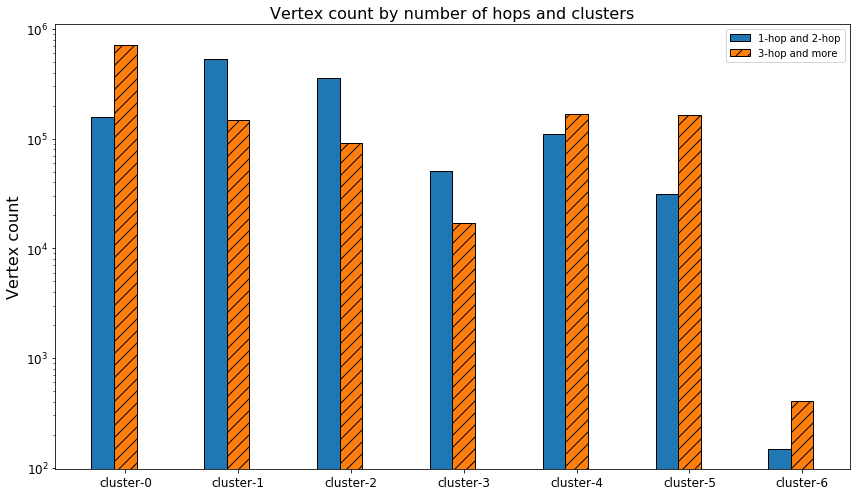

In [22]:
import matplotlib

data_to_plot = []
for i in range(1, 3):
    data_to_plot.append(new_hop_count_df[i].to_numpy())

data_to_plot

# display(data_to_plot)
labels = ['cluster-' + str(i) for i in range(n_clusters)]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(12)

rects = []
tags = ['1-hop and 2-hop', '3-hop and more']

# for i in range(2):
#     rects.append(ax.bar(x+i*width - 2//2 * width, data_to_plot[i].tolist(), width, label=tags[i]))

rects.append(ax.bar(x+0*width - 2//2 * width, data_to_plot[0].tolist(), width, label=tags[0], edgecolor='black'))
rects.append(ax.bar(x+1*width - 2//2 * width, data_to_plot[1].tolist(), width, label=tags[1], edgecolor='black', hatch='//'))

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.title('Vertex count by number of hops and clusters', fontsize=16)
plt.ylabel('Vertex count', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yscale("log")
fig.tight_layout()
plt.savefig(f'./result/{FILE_NAME}/barplot.svg')
plt.show()

In [31]:
hop_ratio = new_hop_count_df[1] / new_hop_count_df[2]
hop_ratio

cluster_0    0.220161
cluster_1    3.550774
cluster_2    3.887365
cluster_3    2.940314
cluster_4    0.658497
cluster_5    0.190070
cluster_6    0.369727
dtype: float64

[0.2201606780848774,
 3.5507740644762813,
 3.887365242699397,
 2.94031425891182,
 0.6584968397088339,
 0.19006990697418397,
 0.369727047146402]

No handles with labels found to put in legend.


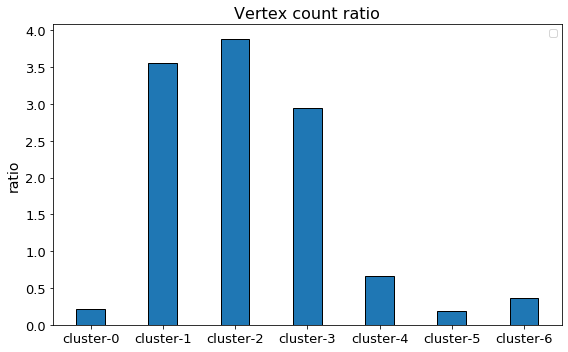

In [47]:
data_to_plot = []
for i in range(7):
    data_to_plot.append(hop_ratio[i])

data_to_plot

display(data_to_plot)
labels = ['cluster-' + str(i) for i in range(n_clusters)]
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)

rects = []

rects.append(ax.bar(x, data_to_plot, width, edgecolor='black'))

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.title('Vertex count ratio', fontsize=16)
plt.ylabel('ratio', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
fig.tight_layout()
plt.savefig(f'./result/{FILE_NAME}/ratio.svg')
plt.show()